In [1]:
import numpy as np
import pandas as pd
import itertools
import math
import random
from statsmodels.formula.api import ols
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import cv2
import os

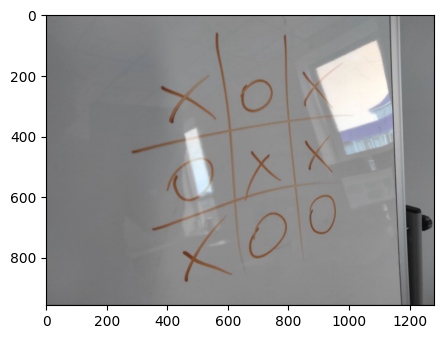

In [2]:
image = cv2.imread('Tic-tac-toe game images/tic_12.jpg')

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.show()

In [3]:
def process_image(image):
    # Підняття рівня чіткості та контрасту
    enhanced = cv2.convertScaleAbs(image, alpha=1.62, beta=0)

    # Перетворення в чорно-біле зображення
    gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    # Застосування медіанного фільтра для зменшення шуму
    blurred = cv2.medianBlur(gray, 5)

    # Застосування фільтру білтеру для виділення контурів та зменшення шуму
    bilateral_filtered = cv2.bilateralFilter(blurred, 9, 75, 75)

    # Використання адаптивної бінаризації для виділення контурів
    thresh = cv2.adaptiveThreshold(bilateral_filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return thresh

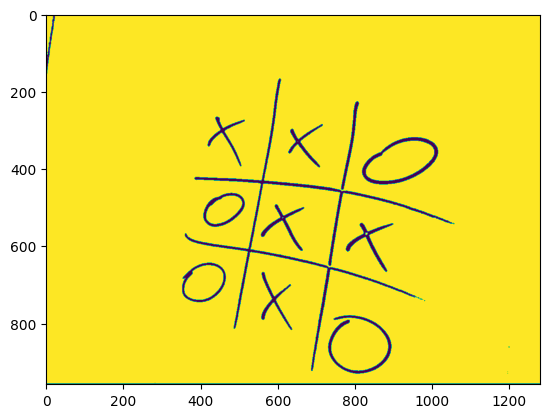

In [4]:
image = cv2.imread('Tic-tac-toe game images/tic_07.jpg')
mask = process_image(image)

plt.imshow(mask)
plt.show()

In [5]:
def pt_line_dist(pt, ref_line):
    pt1, pt2 = [ref_line[:2], ref_line[2:]]
    # Distance from point to line defined by two other points
    return np.linalg.norm(np.cross(pt1 - pt2, [pt[0],pt[1]])) \
         / np.linalg.norm(pt1 - pt2)

def segment_pts(amts, grp_var, grp_label):
    # Segment on amounts (distances here) in last column of array
    # Note: need to label groups with string for OLS model
    amts = amts[amts[:, -1].argsort()]
    first_amt_in_grp = amts[0][-1]
    group, groups, grp = [], [], 0
    for amt in amts:
        if amt[-1] - first_amt_in_grp > grp_var:
            groups.append(group)
            first_amt_in_grp = amt[-1]
            group = []; grp += 1
        group.append(np.append(amt[:-1],[[grp_label + str(grp)]]))
    groups.append(group)
    return groups

def find_reference_line(pts):
    # Find point with minimum absolute slope relative both min y and max y
    y = np.hsplit(pts, 2)[1] # y column of array
    m = []
    for i, y_pt in enumerate([ pts[np.argmin(y)], pts[np.argmax(y)] ]):
        m.append(np.zeros((pts.shape[0]-1, 5))) # dtype default is float64
        m[i][:,2:4] = np.delete(pts, np.where((pts==y_pt).all(axis=1))[0], axis=0)
        m[i][:,4] = abs( (m[i][:,3]-y_pt[1]) / (m[i][:,2]-y_pt[0]) )
        m[i][:,:2] = y_pt
    m = np.vstack((m[0], m[1]))
    return m[np.argmin(m[:,4]), :4]

def get_points(center_boxes):
        # Ignore division by zero (slopes of vertical lines)
    np.seterr(divide='ignore')

    # Create dataset and plot
    pts = np.array(center_boxes)

    # Average distance to the nearest neighbor of each point
    tree = KDTree(pts)
    nn_avg_dist = np.mean(tree.query(pts, 2)[0][:, 1])

    # Find groups of points representing each gridline
    groups = []
    for orientation in ['o', 'r']: #  original and rotated orientations
        
        # Rotate points 90 degrees (note: this moves pts to 2nd quadrant)
        if orientation == 'r':
            pts[:,1] = -1 * pts[:,1]
            pts[:, [1, 0]] = pts[:, [0, 1]]
        
        # Find reference line to compare remaining points for grouping
        ref_line = find_reference_line(pts) # line is defined by two points
        
        # Distances between points and reference line
        pt_dists = np.zeros((pts.shape[0], 3))
        pt_dists[:,:2] = pts
        pt_dists[:,2] = np.apply_along_axis(pt_line_dist, 1, pts, ref_line).T
        
        # Segment pts into groups w.r.t. distances (one group per gridline)
        # Groups have range less than nn_avg_dist.
        groups += segment_pts(pt_dists, 0.5*nn_avg_dist, orientation)

    # Create dataframe of groups (OLS model requires a dataframe)
    df = pd.DataFrame(np.row_stack(groups), columns=['x', 'y', 'grp'])
    df['x'] = pd.to_numeric(df['x'])
    df['y'] = pd.to_numeric(df['y'])

    # Parallel slopes OLS model
    ols_model = ols("y ~ x + grp + 0", data=df).fit()

    # OLS parameters
    grid_lines = ols_model.params[:-1].to_frame() # panda series to dataframe
    grid_lines = grid_lines.rename(columns = {0:'b'})
    grid_lines['grp'] = grid_lines.index.str[4:6]
    grid_lines['m'] = ols_model.params[-1] # slope

    # Rotate the rotated lines back to their original orientation
    grid_lines.loc[grid_lines['grp'].str[0] == 'r', 'b'] = grid_lines['b'] / grid_lines['m']
    grid_lines.loc[grid_lines['grp'].str[0] == 'r', 'm'] = -1 / grid_lines['m']

    # Find grid intersection points by combinations of gridlines
    comb = list(itertools.combinations(grid_lines['grp'], 2))
    comb = [i for i in comb if i[0][0] != 'r']
    comb = [i for i in comb if i[1][0] != 'o']
    df_comb = pd.DataFrame(comb, columns=['grp', 'r_grp'])# Merge gridline parameters with grid points
    grid_pts = df_comb.merge(grid_lines.drop_duplicates('grp'),how='left',on='grp')
    grid_lines.rename(columns={'grp': 'r_grp'}, inplace=True)
    grid_pts.rename(columns={'b':'o_b', 'm': 'o_m', 'grp':'o_grp'}, inplace=True)
    grid_pts = grid_pts.merge(grid_lines.drop_duplicates('r_grp'),how='left',on='r_grp')
    grid_pts.rename(columns={'b':'r_b', 'm': 'r_m'}, inplace=True)

    # Calculate x, y coordinates of gridline interception points
    grid_pts['x'] = (grid_pts['r_b']-grid_pts['o_b']) \
                / (grid_pts['o_m']-grid_pts['r_m'])
    grid_pts['y'] = grid_pts['o_m'] * grid_pts['x'] + grid_pts['o_b']

    return grid_pts

In [6]:
def process_image(image):
    # Підняття рівня чіткості та контрасту
    enhanced = cv2.convertScaleAbs(image, alpha=1.62, beta=0)

    # Перетворення в чорно-біле зображення
    gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    # Застосування медіанного фільтра для зменшення шуму
    blurred = cv2.medianBlur(gray, 5)

    # Застосування фільтру білтеру для виділення контурів та зменшення шуму
    bilateral_filtered = cv2.bilateralFilter(blurred, 9, 75, 75)

    # Використання адаптивної бінаризації для виділення контурів
    thresh = cv2.adaptiveThreshold(bilateral_filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return thresh

In [7]:
def merge_boxes(bounding_boxes):
    # Вибір більшої рамки серед вкладених
    selected_bounding_boxes = []

    for box1 in bounding_boxes:
        is_inside = False
        for box2 in bounding_boxes:
            if (box1 != box2 and
                    box1[0] >= box2[0] and
                    box1[1] >= box2[1] and
                    box1[0] + box1[2] <= box2[0] + box2[2] and
                    box1[1] + box1[3] <= box2[1] + box2[3]):
                is_inside = True
                break
        if not is_inside:
            selected_bounding_boxes.append(box1)
    
    return selected_bounding_boxes

def filter_ratio(bounding_boxes, filter_ratio=2):
    # Вибір більшої та не дуже прямокутної рамки
    selected_bounding_boxes = []

    for x, y, w, h in bounding_boxes:
        aspect_ratio = max(float(w) / h, h / float(w))  # Відношення ширини до висоти
        if aspect_ratio <= filter_ratio:  # Приклад значення для фільтрації
            selected_bounding_boxes.append((x, y, w, h))
    
    return selected_bounding_boxes

def filter_bounding_boxes(bounding_boxes, large_bounding_box, overlap_threshold=0.2):
    x_large, y_large, w_large, h_large = large_bounding_box
    filtered_boxes = []

    for x, y, w, h in bounding_boxes:
        intersection_x = max(x, x_large)
        intersection_y = max(y, y_large)
        intersection_w = min(x + w, x_large + w_large) - intersection_x
        intersection_h = min(y + h, y_large + h_large) - intersection_y

        if intersection_w > 0 and intersection_h > 0:
            intersection_area = intersection_w * intersection_h
            box_area = w * h
            overlap = intersection_area / box_area

            if overlap >= overlap_threshold:
                filtered_boxes.append((x, y, w, h))

    return filtered_boxes

In [8]:
def get_centers(existing_bounding_box):
    x, y, w, h = existing_bounding_box
    
    # Розрахунок центру існуючої рамки
    center_x = x + w // 2
    center_y = y + h // 2

    return center_x, center_y

def points_not_in_boxes(points, boxes):
    # Створіть пустий список для точок, які не належать жодній рамці
    points_not_in_any_box = []

    # Перевірте кожну точку
    for point in points:
        in_any_box = False  # Прапорець, що вказує, чи належить точка якій-небудь рамці

        # Перевірте кожну рамку
        for box in boxes:
            x, y, width, height = box
            x1, x2 = x, x + width
            y1, y2 = y, y + height

            # Перевірте, чи точка знаходиться в межах рамки
            if x1 <= point[0] <= x2 and y1 <= point[1] <= y2:
                in_any_box = True
                break  # Якщо точка вже належить одній рамці, перейдіть до наступної точки

        # Якщо точка не належить жодній рамці, додайте її до списку точок, які не належать жодній рамці
        if not in_any_box:
            points_not_in_any_box.append(point)

    return points_not_in_any_box

def add_midpoints_if_close(points, threshold=1.0):
    num_points = len(points)

    # Створюємо копію списку точок для модифікації
    modified_points = points.copy()

    for i in range(num_points):
        if i < num_points - 1:
            for j in range(i + 1, num_points):
                distance = np.linalg.norm(np.array(points[i]) - np.array(points[j]))
                if distance < threshold:
                    # Обчислюємо середню точку
                    midpoint = tuple(0.5 * (np.array(points[i]) + np.array(points[j])))
                    
                    # Замінюємо обидві точки середньою точкою
                    modified_points[i] = midpoint
                    modified_points[j] = midpoint

    return modified_points

def create_average_boxes(boxes, points):
    # Обчислити середнє арифметичне розмірів введених рамок
    if len(boxes) == 0:
        return None, []

    average_width = int(np.mean([box[2] for box in boxes]))
    average_height = int(np.mean([box[3] for box in boxes]))

    # Створити рамки на основі середнього арифметичного
    created_boxes = [(int(point[0] - average_width // 2), int(point[1] - average_height // 2), int(average_width), int(average_height)) for point in points]

    # Фільтрація створених рамок, щоб вони не пересікалися з існуючими
    filtered_boxes = []
    for created_box in created_boxes:
        intersects = False
        for existing_box in boxes:
            x1, y1, w1, h1 = created_box
            x2, y2, w2, h2 = existing_box
            # Перевірка на перетин
            if x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2:
                intersects = True
                break
        if not intersects:
            filtered_boxes.append(created_box)

    return filtered_boxes

In [9]:
def get_child_contours(contours):
    # Визначте вкладені контури та контури без батьківського контуру
    parent_contours = []
    child_contours = []

    for contour in contours:
        # Визначення кількості вкладених контурів у батьківський контур
        # Наприклад, перевірка, чи центр маси вкладеного контуру знаходиться всередині батьківського контуру
        M = cv2.moments(contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])

            is_inside_parent = False
            for parent in parent_contours:
                if cv2.pointPolygonTest(parent, (cx, cy), False) >= 0:
                    is_inside_parent = True
                    break

            if is_inside_parent:
                child_contours.append(contour)
            else:
                parent_contours.append(contour)
    return child_contours

def fillter_contours(contours):
    # Визначте мінімальну площу для видалення малих контурів
    min_contour_area = 2000  # Приклад значення, налаштуйте відповідно до ваших потреб
    contours = [contour for contour in contours if cv2.contourArea(contour) >= min_contour_area]

    # Знаходження найбільшого контуру за площею
    max_contour = max(contours, key=cv2.contourArea)
    contours.remove(max_contour)

    return contours, max_contour

def increase_box(bounding_boxes, scale_factor=1.2):
    # Збільшені bounding boxes будуть збережені в цьому списку
    enlarged_bounding_boxes = []

    for box in bounding_boxes:
        x, y, w, h = box
        # Розрахунок нового розміру збільшеної рамки
        new_w = int(w * scale_factor)
        new_h = int(h * scale_factor)
        # Розрахунок нових координат так, щоб рамка залишалася в центрі
        new_x = x - (new_w - w) // 2
        new_y = y - (new_h - h) // 2
        # Додавання збільшеної рамки до списку
        enlarged_bounding_boxes.append([new_x, new_y, new_w, new_h])
    
    return enlarged_bounding_boxes

In [10]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans

# Завантажимо попередньо навчену модель VGG16 і відключимо верхній класифікатор
model = VGG16(weights='imagenet', include_top=False)

# Функція для завантаження та підготовки зображення
def load_and_preprocess_image(filename, target_size=(32, 32)):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = preprocess_input(image)
    return image

C:\Users\krapa\AppData\Local\Temp\ipykernel_14840\978065074.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours.remove(max_contour)


(-0.5, 1279.5, 957.5, -0.5)

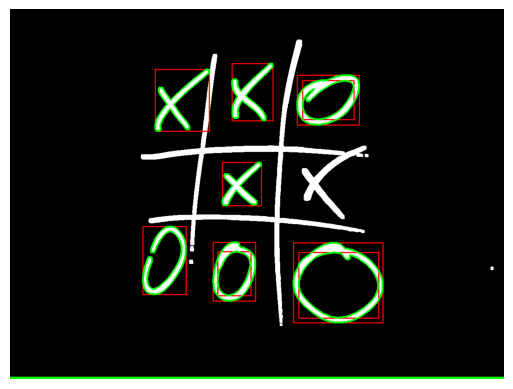

In [11]:
image = cv2.imread('Tic-tac-toe game images/tic_01.jpg')

mask = process_image(image)

_ , mask = cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)
mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
mask = cv2.bitwise_not(mask)

contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, max_contour = fillter_contours(contours)

child_contours = get_child_contours(contours)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, max_contour = fillter_contours(contours)

contours = contours + child_contours

contours_img = mask.copy()
contours_img = cv2.cvtColor(contours_img, cv2.COLOR_GRAY2BGR)

for contour in contours+child_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contours_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Малювання прямокутника навколо контуру

cv2.drawContours(contours_img, contours + child_contours, -1, (0, 255, 0), 3)

plt.imshow(contours_img)
plt.axis('off')

In [12]:
def get_image_bounding_boxes(image):
    mask = process_image(image)

    _ , mask = cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)
    mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
    mask = cv2.bitwise_not(mask)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, max_contour = fillter_contours(contours)

    child_contours = get_child_contours(contours)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours, max_contour = fillter_contours(contours)

    contours = contours + child_contours

    # Збереження масиву рамок
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    bounding_boxes = merge_boxes(bounding_boxes)
    bounding_boxes = filter_ratio(bounding_boxes, filter_ratio=2.5)
    bounding_boxes = filter_bounding_boxes(bounding_boxes, cv2.boundingRect(max_contour))

    center_boxes = [get_centers(box) for box in bounding_boxes]

    grid_pts = get_points(center_boxes)
    center_points = list(zip(grid_pts['x'], grid_pts['y']))

    filtered_points = points_not_in_boxes(center_points, bounding_boxes)

    bounding_boxes = bounding_boxes + create_average_boxes(bounding_boxes, filtered_points)

    return bounding_boxes

In [13]:
def label_bounding_boxes(main_image, bounding_boxes):    
    # Завантажуємо та підготовлюємо всі картинки з каталогу
    image_filenames = [os.path.join('images/', filename) for filename in os.listdir('images/')][1:]
    images = [load_and_preprocess_image(filename) for filename in image_filenames]

    imgs = []
    for image in images:
        imgs.append({'image': image, 'box': None, 'label': ''})

    for i, rect in enumerate(bounding_boxes):
        x, y, w, h = rect
        img = main_image[y:y+h, x:x+w]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32, 32))
        img = preprocess_input(img)

        imgs.append({'image': img, 'box': rect, 'label': ''})


    # Витягуємо ознаки з кожної картинки за допомогою VGG16
    features = [model.predict(np.expand_dims(image['image'], axis=0)).flatten() for image in imgs]

    # Кластеризуємо ознаки за допомогою K-Means
    num_clusters = 3  # Задайте кількість кластерів
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(features)

    # Визначаємо, які картинки відносяться до якого кластера
    cluster_labels = kmeans.labels_

    # Створюємо порожні списки для кожного кластера
    clusters = [[] for _ in range(num_clusters)]

    # Визначаємо, які картинки відносяться до якого кластера
    for i in range(len(cluster_labels)):
        imgs[i]['label'] = cluster_labels[i]

    return imgs

C:\Users\krapa\AppData\Local\Temp\ipykernel_14840\978065074.py:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours.remove(max_contour)
c:\Users\krapa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


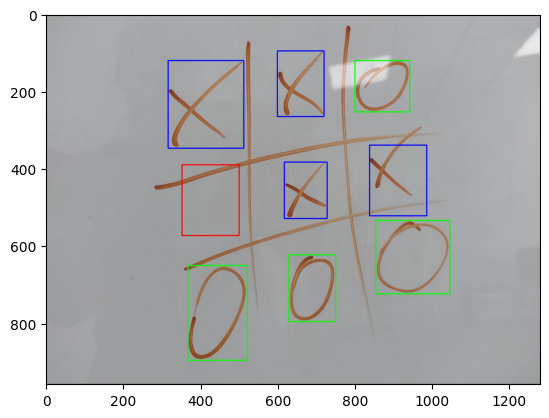

In [14]:
image = cv2.imread('Tic-tac-toe game images/tic_02.jpg')
bounding_boxes = get_image_bounding_boxes(image)
imgs = label_bounding_boxes(image, bounding_boxes)

# Створити копію зображення
image_with_boxes = image

# Пройтися по списку dict і намалювати рамки з відповідним кольором
for item in imgs:
    if item['box']:
        x, y, w, h = item['box']
        color = (255, 0, 0)
        if item['label'] == 1:
            color = (0, 255, 0)
        elif item['label'] == 2:
            color = (0, 0, 255)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2)

plt.imshow(image_with_boxes)
plt.show()

In [15]:
def check_winner(board):
    # Перевірка рядків, стовпців та діагоналей на переможця
    for i in range(3):
        # Перевірка рядків
        if board[i][0]['label'] == board[i][1]['label'] == board[i][2]['label'] and board[i][0] != 'blank':
            return [(i, 0), (i, 1), (i, 2)]

        # Перевірка стовпців
        if board[0][i]['label'] == board[1][i]['label'] == board[2][i]['label'] and board[0][i]['label'] != 'blank':
            return [(0, i), (1, i), (2, i)]

    # Перевірка головної діагоналі
    if board[0][0]['label'] == board[1][1]['label'] == board[2][2]['label'] and board[0][0]['label'] != 'blank':
        return [(0, 0), (1, 1), (2, 2)]

    # Перевірка протилежної діагоналі
    if board[0][2]['label'] == board[1][1]['label'] == board[2][0]['label'] and board[0][2]['label'] != 'blank':
        return [(0, 2), (1, 1), (2, 0)]

    # Якщо немає переможця
    return None, None

In [16]:
blank_label = 'blank'
for img in imgs:
    if img['box'] is None:
        blank_label = img['label']
        break

for img in imgs:
    if img['label'] == blank_label:
        img['label'] = 'blank'

imgs = list(filter(lambda x: x['box'], imgs))
imgs = sorted(imgs, key=lambda x: x['box'][1])

a1 = sorted(imgs[:3], key=lambda x: x['box'][0])
a2 = sorted(imgs[3:6], key=lambda x: x['box'][0])
a3 = sorted(imgs[6:], key=lambda x: x['box'][0])

board = [a1, a2, a3]

winning_cells = check_winner(board)

if winning_cells is not None:
    print(f'Індекси виграшних клітинок: {winning_cells[0], winning_cells[2]}')
else:
    print('Немає переможця.')

box1 = board[winning_cells[0][0]][winning_cells[0][1]]['box']
box2 = board[winning_cells[2][0]][winning_cells[2][1]]['box']
print(box1, box2)

Індекси виграшних клітинок: ((2, 0), (2, 2))
(367, 651, 154, 245) (854, 534, 192, 190)


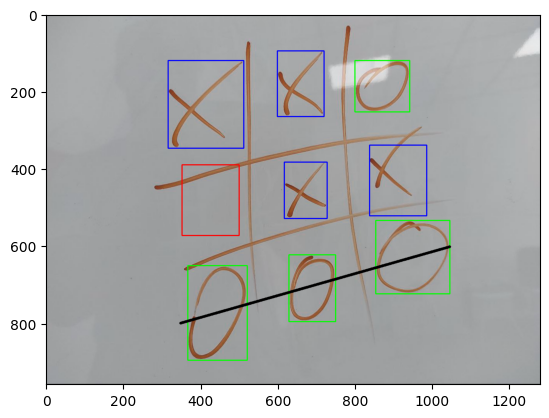

In [17]:
final_image = image

# Визначення центрів рамок
point1 = (box1[0] + box1[2] // 2, box1[1] + box1[3] // 2)
point2 = (box2[0] + box2[2] // 2, box2[1] + box2[3] // 2)

extension_length = 100
# Розрахунок нових координат точок
dx = point2[0] - point1[0]
dy = point2[1] - point1[1]
length = np.sqrt(dx**2 + dy**2)
new_x1 = point1[0] - int(dx / length * extension_length)
new_y1 = point1[1] - int(dy / length * extension_length)
new_x2 = point2[0] + int(dx / length * extension_length)
new_y2 = point2[1] + int(dy / length * extension_length)

# Малювання лінії
cv2.line(final_image, (new_x1, new_y1), (new_x2, new_y2), (0, 0, 0), 5)  # Зелена лінія

plt.imshow(final_image)
plt.show()